In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [3]:
df = mb.bindome.datasets.PBM.gcn4_dream_v11()
df = df.sort_values('intensity', ascending=False).reset_index(drop=True)

In [4]:
df

,tf.name,tech,intensity,seq
0,gcn4.v11,upbm,437117.583408,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAGTCTGTGTTC...
1,gcn4.v11,upbm,409629.925695,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAGTCTGTGTTC...
2,gcn4.v11,upbm,390667.969212,CTAGTATGATGCTAACAGCATGATGACTCATACCGAGTCTGTGTTC...
3,gcn4.v11,upbm,377628.072915,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAGTCTGTGTTC...
4,gcn4.v11,upbm,360399.922962,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAGTCTGTGTTC...
...,...,...,...,...
41899,gcn4.v11,upbm,5709.272026,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCGTCTGTGTTC...
41900,gcn4.v11,upbm,5058.172853,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCGTCTGTGTTC...
41901,gcn4.v11,upbm,4634.742298,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGGTCTGTGTTC...
41902,gcn4.v11,upbm,2481.035063,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACGTCTGTGTTC...


In [5]:
df = df[['seq', 'intensity']]
df.columns = ['seq', 0]

In [60]:
data = df.copy() # head(10000)
# data = df.sample(n=10000)

In [61]:
data[1] = data[0]
data[0] = np.median(data[1])

data[0] = np.log(data[0])
data[1] = np.log(data[1])

In [62]:
data['seq'] = data['seq'].str[:-23]

In [63]:
data

,seq,0,1
0,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAG,9.91054,12.987958
1,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAG,9.91054,12.923009
2,CTAGTATGATGCTAACAGCATGATGACTCATACCGAG,9.91054,12.875613
3,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAG,9.91054,12.841665
4,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAG,9.91054,12.794970
...,...,...,...
41899,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCG,9.91054,8.649847
41900,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCG,9.91054,8.528761
41901,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGG,9.91054,8.441336
41902,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACG,9.91054,7.816431


<AxesSubplot:>

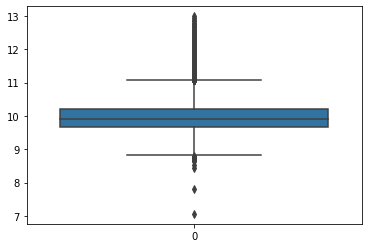

In [10]:
sns.boxplot(data=np.array(data[1]))

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

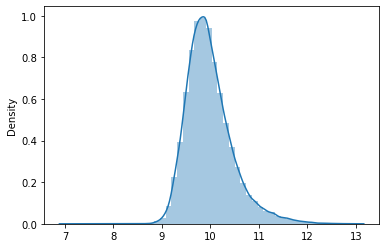

In [67]:
sns.distplot(np.array(data[1]))

In [11]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [12]:
print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=1, enr_series=True)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)

loading object (# entries) 41904


# DinucSelex model with MSE Loss

In [31]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14], n_rounds=1, n_batches=1).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()
criterion = mb.tl.MSELoss()

In [32]:
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 0.057099 , best epoch: 9 secs per epoch: 1.271 s
Epoch: 21, Loss: 0.056050 , best epoch: 19 secs per epoch: 1.188 s
Epoch: 31, Loss: 0.055473 , best epoch: 29 secs per epoch: 1.190 s
Epoch: 41, Loss: 0.053915 , best epoch: 39 secs per epoch: 1.190 s
Epoch: 51, Loss: 0.050002 , best epoch: 49 secs per epoch: 1.190 s
Epoch: 61, Loss: 0.046573 , best epoch: 59 secs per epoch: 1.186 s
Epoch: 71, Loss: 0.041615 , best epoch: 69 secs per epoch: 1.193 s
Epoch: 81, Loss: 0.040195 , best epoch: 79 secs per epoch: 1.201 s
Epoch: 91, Loss: 0.039400 , best epoch: 89 secs per epoch: 1.207 s
Epoch: 101, Loss: 0.039112 , best epoch: 99 secs per epoch: 1.211 s
Epoch: 111, Loss: 0.038705 , best epoch: 109 secs per epoch: 1.215 s
Epoch: 121, Loss: 0.038601 , best epoch: 115 secs per epoch: 1.219 s
Epoch: 131, Loss: 0.03852


#activities
[[[1.0001314  0.76389295]
  [1.0001577  0.7258457 ]]]

#log_etas
Parameter containing:
tensor([[ 0.2741, -0.2741]], requires_grad=True)


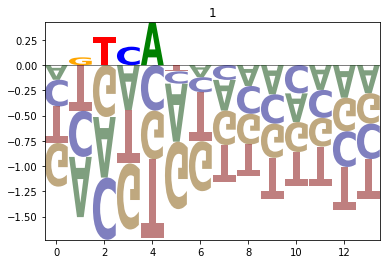

In [33]:
mb.pl.conv_mono(model)

In [34]:
seqs, targets, preds = mb.tl.test_network(model, train, device)

In [35]:
preds

array([[10.039406 ,  9.842761 ],
       [ 9.941302 , 10.079111 ],
       [10.207384 , 10.460086 ],
       ...,
       [ 9.6669235,  9.722008 ],
       [ 9.9579735, 10.446244 ],
       [ 9.707914 ,  9.936019 ]], dtype=float32)

In [36]:
targets

array([[ 9.91054 ,  9.971628],
       [ 9.91054 , 10.109875],
       [ 9.91054 , 10.756928],
       ...,
       [ 9.91054 ,  9.478391],
       [ 9.91054 , 10.493678],
       [ 9.91054 ,  9.733394]], dtype=float32)

In [39]:
len(seqs[0])

37

# DinucPBM model, predicting the scores without etas and normalizing layer and without median control

In [13]:
data2 = df.copy()
data2[0] = np.log(data2[0])
data2['seq'] = data2['seq'].str[:-23]
dataset2 = mb.datasets.SelexDataset(data2, n_rounds=0, enr_series=False)
train2 = tdata.DataLoader(dataset=dataset2, batch_size=256, shuffle=True)

In [43]:
data2

,seq,0
0,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAG,12.987958
1,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAG,12.923009
2,CTAGTATGATGCTAACAGCATGATGACTCATACCGAG,12.875613
3,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAG,12.841665
4,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAG,12.794970
...,...,...
41899,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCG,8.649847
41900,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCG,8.528761
41901,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGG,8.441336
41902,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACG,7.816431


In [47]:
model = mb.models.DinucPBM(use_dinuc=False, kernels=[0, 14], n_rounds=0, n_batches=1, enr_series=False).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()
criterion = mb.tl.MSELoss()

In [48]:
mb.tl.train_network(model, train2, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 0.555327 , best epoch: 9 secs per epoch: 1.216 s
Epoch: 21, Loss: 0.360746 , best epoch: 19 secs per epoch: 1.162 s
Epoch: 31, Loss: 0.316947 , best epoch: 29 secs per epoch: 1.146 s
Epoch: 41, Loss: 0.262136 , best epoch: 39 secs per epoch: 1.140 s
Epoch: 51, Loss: 0.227957 , best epoch: 49 secs per epoch: 1.140 s
Epoch: 61, Loss: 0.221969 , best epoch: 59 secs per epoch: 1.133 s
Epoch: 71, Loss: 0.220576 , best epoch: 69 secs per epoch: 1.130 s
Epoch: 81, Loss: 0.217221 , best epoch: 79 secs per epoch: 1.128 s
Epoch: 91, Loss: 0.209439 , best epoch: 89 secs per epoch: 1.126 s
Epoch: 101, Loss: 0.197031 , best epoch: 99 secs per epoch: 1.126 s
Epoch: 111, Loss: 0.186685 , best epoch: 109 secs per epoch: 1.121 s
Epoch: 121, Loss: 0.180750 , best epoch: 119 secs per epoch: 1.121 s
Epoch: 131, Loss: 0.17763


#activities
[[[0.68714225]
  [0.8506053 ]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


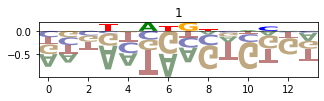

In [49]:
mb.pl.conv_mono(model)

# DinucPBM model, predicting transformed scores (currently best)

In [58]:
data4

,seq,0
0,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAG,3.077418
1,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAG,3.012470
2,CTAGTATGATGCTAACAGCATGATGACTCATACCGAG,2.965073
3,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAG,2.931125
4,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAG,2.884430
...,...,...
41899,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCG,-1.260693
41900,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCG,-1.381779
41901,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGG,-1.469204
41902,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACG,-2.094109


In [6]:
data3 = df.copy()
data3[0] = np.log(data3[0])
data3['seq'] = data3['seq'].str[:-23]
data3[0] = np.exp(data3[0] - np.median(data3[0]))
data3

,seq,0
0,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAG,21.702287
1,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAG,20.337562
2,CTAGTATGATGCTAACAGCATGATGACTCATACCGAG,19.396127
3,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAG,18.748714
4,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAG,17.893360
...,...,...
41899,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCG,0.283458
41900,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCG,0.251131
41901,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGG,0.230109
41902,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACG,0.123180


In [7]:
dataset3 = mb.datasets.SelexDataset(data3, n_rounds=0, enr_series=False)
train3 = tdata.DataLoader(dataset=dataset3, batch_size=256, shuffle=True)

In [26]:
model = mb.models.DinucPBM(use_dinuc=False, kernels=[0, 14], n_rounds=0, n_batches=1, enr_series=False).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()
criterion = mb.tl.MSELoss()

In [27]:
mb.tl.train_network(model, train3, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 0.857221 , best epoch: 9 secs per epoch: 1.325 s
Epoch: 21, Loss: 0.847317 , best epoch: 19 secs per epoch: 1.208 s
Epoch: 31, Loss: 0.843688 , best epoch: 29 secs per epoch: 1.187 s
Epoch: 41, Loss: 0.827977 , best epoch: 39 secs per epoch: 1.169 s
Epoch: 51, Loss: 0.633883 , best epoch: 49 secs per epoch: 1.166 s
Epoch: 61, Loss: 0.525317 , best epoch: 59 secs per epoch: 1.154 s
Epoch: 71, Loss: 0.462887 , best epoch: 69 secs per epoch: 1.161 s
Epoch: 81, Loss: 0.434576 , best epoch: 78 secs per epoch: 1.157 s
Epoch: 91, Loss: 0.424734 , best epoch: 89 secs per epoch: 1.153 s
Epoch: 101, Loss: 0.420110 , best epoch: 99 secs per epoch: 1.155 s
Epoch: 111, Loss: 0.418003 , best epoch: 109 secs per epoch: 1.153 s
Epoch: 121, Loss: 0.417047 , best epoch: 119 secs per epoch: 1.151 s
Epoch: 131, Loss: 0.41645

In [37]:
torch.sum(torch.exp(model.conv_mono[1].weight), dim=2)

tensor([[[2.7485, 2.6625, 2.6911, 2.6991, 2.7092, 3.5406, 6.1935, 4.8695,
          6.1775, 4.2452, 2.9626, 2.9171, 3.0417, 2.5371]]],
       grad_fn=<SumBackward1>)

Same dataset, but PBM model with log output

In [26]:
model = mb.models.DinucPBM(use_dinuc=False, kernels=[0, 14], n_rounds=0, n_batches=1, enr_series=False).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()
criterion = mb.tl.MSELoss()

In [27]:
mb.tl.train_network(model, train3, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 0.857221 , best epoch: 9 secs per epoch: 1.325 s
Epoch: 21, Loss: 0.847317 , best epoch: 19 secs per epoch: 1.208 s
Epoch: 31, Loss: 0.843688 , best epoch: 29 secs per epoch: 1.187 s
Epoch: 41, Loss: 0.827977 , best epoch: 39 secs per epoch: 1.169 s
Epoch: 51, Loss: 0.633883 , best epoch: 49 secs per epoch: 1.166 s
Epoch: 61, Loss: 0.525317 , best epoch: 59 secs per epoch: 1.154 s
Epoch: 71, Loss: 0.462887 , best epoch: 69 secs per epoch: 1.161 s
Epoch: 81, Loss: 0.434576 , best epoch: 78 secs per epoch: 1.157 s
Epoch: 91, Loss: 0.424734 , best epoch: 89 secs per epoch: 1.153 s
Epoch: 101, Loss: 0.420110 , best epoch: 99 secs per epoch: 1.155 s
Epoch: 111, Loss: 0.418003 , best epoch: 109 secs per epoch: 1.153 s
Epoch: 121, Loss: 0.417047 , best epoch: 119 secs per epoch: 1.151 s
Epoch: 131, Loss: 0.41645

In [37]:
torch.sum(torch.exp(model.conv_mono[1].weight), dim=2)

tensor([[[2.7485, 2.6625, 2.6911, 2.6991, 2.7092, 3.5406, 6.1935, 4.8695,
          6.1775, 4.2452, 2.9626, 2.9171, 3.0417, 2.5371]]],
       grad_fn=<SumBackward1>)

In [45]:
seqs, targets, preds = mb.tl.test_network(model, train3, device)

In [46]:
targets

array([[1.0109937],
       [1.0053301],
       [1.8130571],
       ...,
       [3.360535 ],
       [6.0414567],
       [0.6806797]], dtype=float32)

In [47]:
preds

array([[0.93441385],
       [0.9532871 ],
       [1.2958099 ],
       ...,
       [3.5755725 ],
       [4.327273  ],
       [0.9446228 ]], dtype=float32)

<AxesSubplot:>

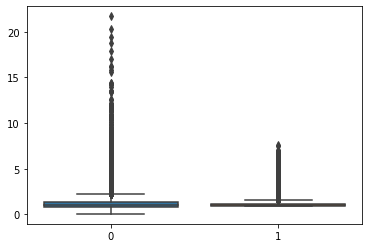

In [49]:
sns.boxplot(data=(targets, preds))

DinucPBM model with log output

In [11]:
data4 = df.copy()
data4[0] = np.log(data4[0])
data4['seq'] = data4['seq'].str[:-23]
data4[0] = data4[0] - np.median(data4[0])
data4

,seq,0
0,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAG,3.077418
1,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAG,3.012470
2,CTAGTATGATGCTAACAGCATGATGACTCATACCGAG,2.965073
3,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAG,2.931125
4,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAG,2.884430
...,...,...
41899,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCG,-1.260693
41900,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCG,-1.381779
41901,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGG,-1.469204
41902,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACG,-2.094109


In [12]:
dataset4 = mb.datasets.SelexDataset(data4, n_rounds=0, enr_series=False)
train4 = tdata.DataLoader(dataset=dataset4, batch_size=256, shuffle=True)

In [15]:
model = mb.models.DinucPBM(use_dinuc=False, kernels=[0, 14], n_rounds=0, n_batches=1, enr_series=False).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()
criterion = mb.tl.MSELoss()

In [16]:
mb.tl.train_network(model, train4, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 0.229677 , best epoch: 9 secs per epoch: 1.196 s
Epoch: 21, Loss: 0.227180 , best epoch: 19 secs per epoch: 1.148 s
Epoch: 31, Loss: 0.224654 , best epoch: 29 secs per epoch: 1.128 s
Epoch: 41, Loss: 0.223379 , best epoch: 39 secs per epoch: 1.108 s
Epoch: 51, Loss: 0.214090 , best epoch: 49 secs per epoch: 1.101 s
Epoch: 61, Loss: 0.153766 , best epoch: 59 secs per epoch: 1.095 s
Epoch: 71, Loss: 0.136471 , best epoch: 69 secs per epoch: 1.097 s
Epoch: 81, Loss: 0.129770 , best epoch: 79 secs per epoch: 1.100 s
Epoch: 91, Loss: 0.125613 , best epoch: 89 secs per epoch: 1.099 s
Epoch: 101, Loss: 0.123532 , best epoch: 99 secs per epoch: 1.099 s
Epoch: 111, Loss: 0.122848 , best epoch: 109 secs per epoch: 1.096 s
Epoch: 121, Loss: 0.122533 , best epoch: 118 secs per epoch: 1.092 s
Epoch: 131, Loss: 0.12242


#activities
[[[1.0012171]
  [1.4457681]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


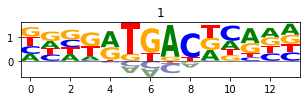

In [17]:
mb.pl.conv_mono(model)

# DinucPBM with log output, but untransformed Pbm-Signal

In [20]:
data5 = df.copy()
data5[0] = np.log(data5[0])
data5['seq'] = data5['seq'].str[:-23]
data5

,seq,0
0,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAG,12.987958
1,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAG,12.923009
2,CTAGTATGATGCTAACAGCATGATGACTCATACCGAG,12.875613
3,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAG,12.841665
4,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAG,12.794970
...,...,...
41899,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCG,8.649847
41900,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCG,8.528761
41901,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGG,8.441336
41902,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACG,7.816431


In [23]:
dataset5 = mb.datasets.SelexDataset(data4, n_rounds=0, enr_series=False)
train5 = tdata.DataLoader(dataset=dataset4, batch_size=256, shuffle=True)

In [21]:
model = mb.models.DinucPBM(use_dinuc=False, kernels=[0, 14], n_rounds=0, n_batches=1, enr_series=False).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()
criterion = mb.tl.MSELoss()

In [24]:
mb.tl.train_network(model, train5, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 0.233057 , best epoch: 9 secs per epoch: 1.354 s
Epoch: 21, Loss: 0.229300 , best epoch: 19 secs per epoch: 1.268 s
Epoch: 31, Loss: 0.225362 , best epoch: 29 secs per epoch: 1.239 s
Epoch: 41, Loss: 0.223486 , best epoch: 39 secs per epoch: 1.226 s
Epoch: 51, Loss: 0.214918 , best epoch: 49 secs per epoch: 1.217 s
Epoch: 61, Loss: 0.154802 , best epoch: 59 secs per epoch: 1.196 s
Epoch: 71, Loss: 0.137201 , best epoch: 69 secs per epoch: 1.189 s
Epoch: 81, Loss: 0.129446 , best epoch: 79 secs per epoch: 1.188 s
Epoch: 91, Loss: 0.124887 , best epoch: 89 secs per epoch: 1.185 s
Epoch: 101, Loss: 0.122664 , best epoch: 99 secs per epoch: 1.178 s
Epoch: 111, Loss: 0.121930 , best epoch: 109 secs per epoch: 1.174 s
Epoch: 121, Loss: 0.121659 , best epoch: 119 secs per epoch: 1.179 s
Epoch: 131, Loss: 0.12151


#activities
[[[0.72551113]
  [0.56121445]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


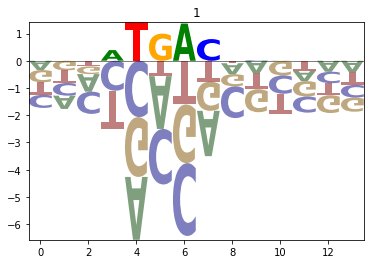

In [25]:
mb.pl.conv_mono(model)

# DinucPBM: Allowing the activities to become negative (= not applying exp to the log_activites)

In [50]:
data4

,seq,0
0,CGCTGATAATGAGTCACACCTTGCCTTCCAGACAAAG,3.077418
1,TCCTGTGACTCATCCATACTCGAACATCCTTATGGAG,3.012470
2,CTAGTATGATGCTAACAGCATGATGACTCATACCGAG,2.965073
3,TTGCGTGGTCGTCGTATTGTATGACTCATGAATTTAG,2.931125
4,TGTGAGTGACTCATAGTAGATTGATTTGAAGGTTAAG,2.884430
...,...,...
41899,CCGGGCTAAGAAAGGATGGAGCGCTAGTCCGGGTGCG,-1.260693
41900,AGAGCCATCAAGCTCCTATCTAGGACGGCCGAGCGCG,-1.381779
41901,GATGCAAGATAAAATAGATTCGGAGCTTCTAGAATGG,-1.469204
41902,CACGCCATCGTTATGAGCCTCCGGAGCGTTTAGAACG,-2.094109


In [55]:
model = mb.models.DinucPBM(use_dinuc=False, kernels=[0, 14], n_rounds=0, n_batches=1, enr_series=False).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()
criterion = mb.tl.MSELoss()

In [56]:
mb.tl.train_network(model, train4, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 0.224058 , best epoch: 9 secs per epoch: 1.232 s
Epoch: 21, Loss: 0.188934 , best epoch: 19 secs per epoch: 1.182 s
Epoch: 31, Loss: 0.181855 , best epoch: 29 secs per epoch: 1.197 s
Epoch: 41, Loss: 0.136675 , best epoch: 39 secs per epoch: 1.194 s
Epoch: 51, Loss: 0.129600 , best epoch: 49 secs per epoch: 1.176 s
Epoch: 61, Loss: 0.127634 , best epoch: 59 secs per epoch: 1.162 s
Epoch: 71, Loss: 0.126298 , best epoch: 69 secs per epoch: 1.151 s
Epoch: 81, Loss: 0.125723 , best epoch: 79 secs per epoch: 1.151 s
Epoch: 91, Loss: 0.125372 , best epoch: 87 secs per epoch: 1.151 s
Epoch: 101, Loss: 0.125292 , best epoch: 91 secs per epoch: 1.151 s
Epoch: 111, Loss: 0.125192 , best epoch: 109 secs per epoch: 1.151 s
Epoch: 120, Loss: 0.1252 , best epoch: 109 secs per epoch: 1.150 s
early stop!
total time: 136


#activities
[[[-0.33224803]
  [ 0.03770812]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


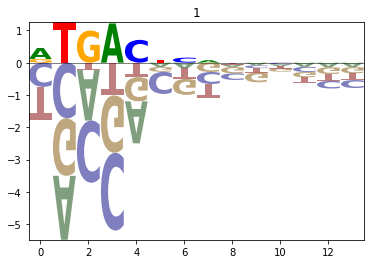

In [57]:
mb.pl.conv_mono(model)

# Current implementation (with train_iterative)

In [6]:
data = df.copy()
data[0] = np.log(data[0])
data['seq'] = data['seq'].str[:-23]
dataset = mb.datasets.SelexDataset(data, n_rounds=0, enr_series=False)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)

# rounds 0
# batches 1
# enr_series False
next w 15 <class 'int'>

Kernel to optimize 0

Freezing kernels
setting grad status of kernel at 0 to 1
setting grad status of kernel at 1 to 0


before kernel optimization.


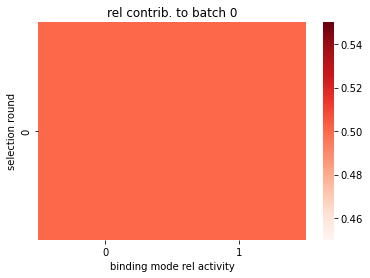


#activities
[[[1.]
  [1.]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


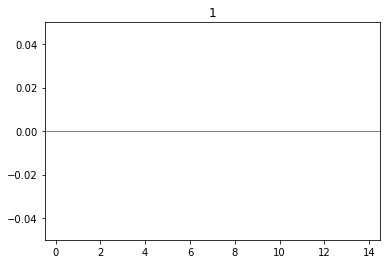

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


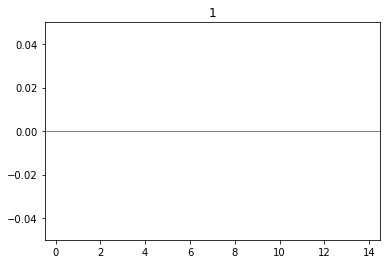

kernels mask None
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 8470.158267 , best epoch: 9 secs per epoch: 1.124 s
Epoch: 21, Loss: 8468.447351 , best epoch: 19 secs per epoch: 1.076 s
Epoch: 31, Loss: 8468.016106 , best epoch: 29 secs per epoch: 1.063 s
Epoch: 41, Loss: 8467.926483 , best epoch: 38 secs per epoch: 1.065 s
Epoch: 51, Loss: 8467.865775 , best epoch: 45 secs per epoch: 1.056 s
Epoch: 61, Loss: 8467.831993 , best epoch: 58 secs per epoch: 1.049 s
Epoch: 71, Loss: 8467.811050 , best epoch: 69 secs per epoch: 1.049 s
Epoch: 81, Loss: 8467.823019 , best epoch: 69 secs per epoch: 1.048 s
Epoch: 85, Loss: 8467.7981 , best epoch: 69 secs per epoch: 1.049 s
early stop!
total time: 88.099 s
secs per epoch: 1.049 s

##After kernel opt / before shift optim.


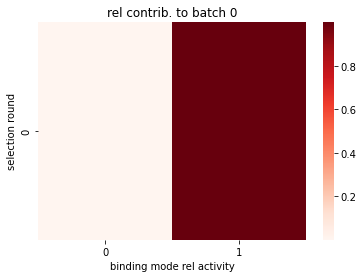


#activities
[[[7.376301e-05]
  [1.000000e+00]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


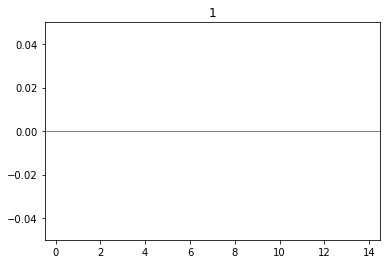

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


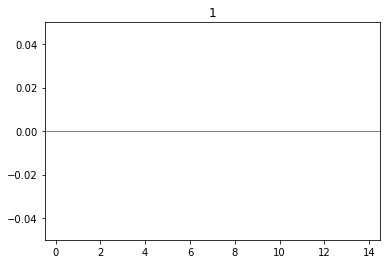

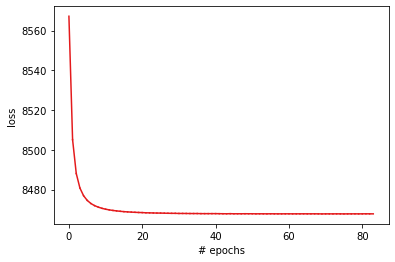

after shift optimz model


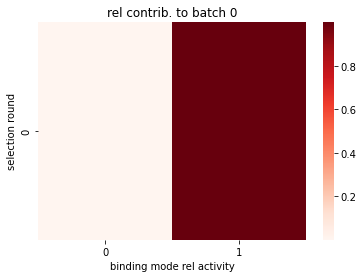


#activities
[[[7.376301e-05]
  [1.000000e+00]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


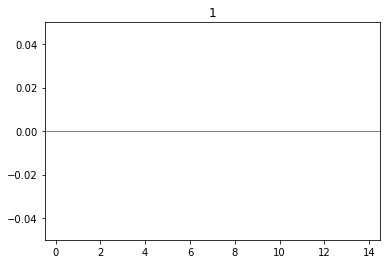

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


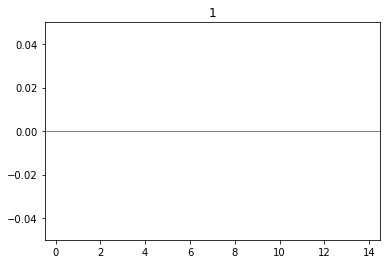

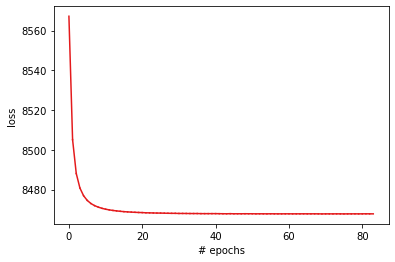



Kernel to optimize 1

Freezing kernels
setting grad status of kernel at 0 to 0
setting grad status of kernel at 1 to 1


before kernel optimization.


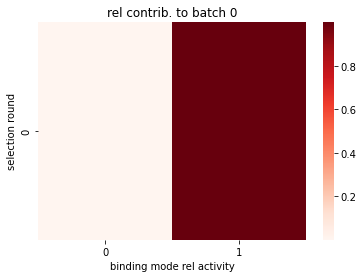


#activities
[[[7.376301e-05]
  [1.000000e+00]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


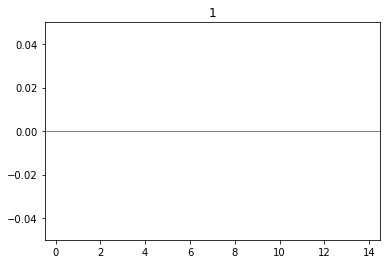

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


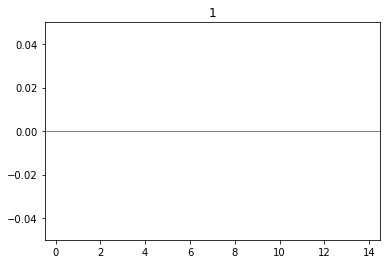

kernels mask None
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.225057 , best epoch: 9 secs per epoch: 1.541 s
Epoch: 21, Loss: 0.224095 , best epoch: 19 secs per epoch: 1.503 s
Epoch: 31, Loss: 0.224388 , best epoch: 23 secs per epoch: 1.475 s
Epoch: 39, Loss: 0.2242 , best epoch: 23 secs per epoch: 1.446 s
early stop!
total time: 54.953 s
secs per epoch: 1.446 s

##After kernel opt / before shift optim.


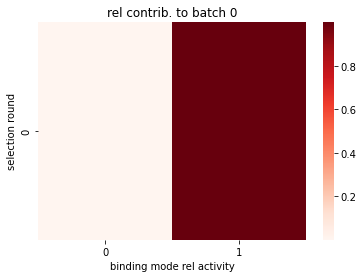


#activities
[[[7.3763011e-05]
  [8.6474156e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


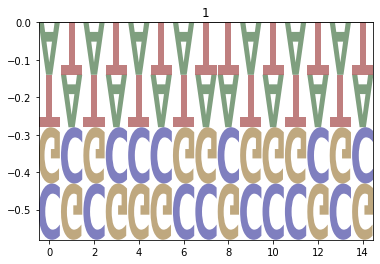

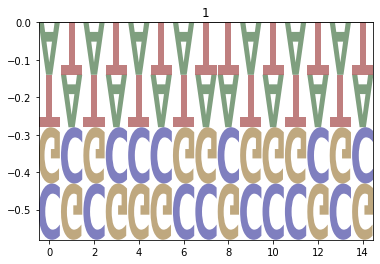

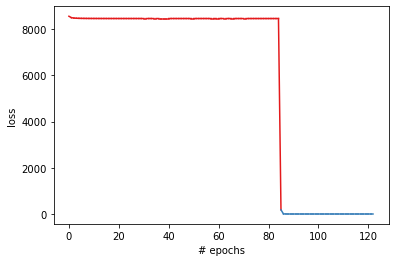


optimize_motif_shift (first)...
next expand left: 1, next expand right: 1, shift: 0
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.211813 , best epoch: 9 secs per epoch: 0.597 s
Epoch: 21, Loss: 0.200271 , best epoch: 18 secs per epoch: 0.569 s
Epoch: 31, Loss: 0.200487 , best epoch: 18 secs per epoch: 0.558 s
Epoch: 34, Loss: 0.2027 , best epoch: 18 secs per epoch: 0.557 s
early stop!
total time: 18.387 s
secs per epoch: 0.557 s
after opt.

#activities
[[[7.376301e-05]
  [8.569001e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


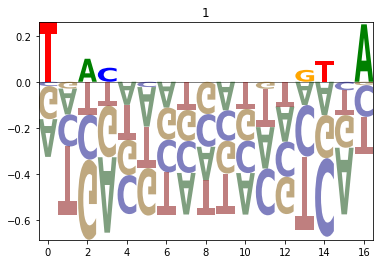

next expand left: 1, next expand right: 2, shift: 0
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.186025 , best epoch: 9 secs per epoch: 0.582 s
Epoch: 21, Loss: 0.161446 , best epoch: 18 secs per epoch: 0.554 s
Epoch: 31, Loss: 0.163063 , best epoch: 21 secs per epoch: 0.544 s
Epoch: 37, Loss: 0.1647 , best epoch: 21 secs per epoch: 0.545 s
early stop!
total time: 19.618 s
secs per epoch: 0.545 s
after opt.

#activities
[[[7.376301e-05]
  [8.557805e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


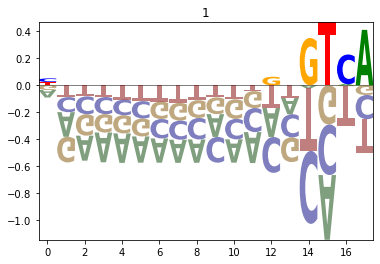

next expand left: 2, next expand right: 1, shift: 0
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.185819 , best epoch: 8 secs per epoch: 0.572 s
Epoch: 21, Loss: 0.159292 , best epoch: 17 secs per epoch: 0.543 s
Epoch: 31, Loss: 0.165667 , best epoch: 26 secs per epoch: 0.538 s
Epoch: 41, Loss: 0.168348 , best epoch: 38 secs per epoch: 0.535 s
Epoch: 51, Loss: 0.160806 , best epoch: 38 secs per epoch: 0.535 s
Epoch: 54, Loss: 0.1587 , best epoch: 38 secs per epoch: 0.534 s
early stop!
total time: 28.303 s
secs per epoch: 0.534 s
after opt.

#activities
[[[7.3763011e-05]
  [8.5215306e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


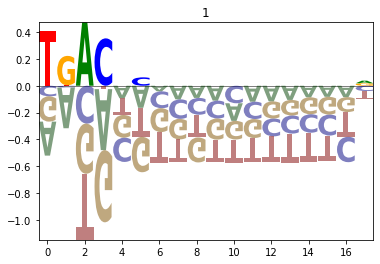

next expand left: 2, next expand right: 2, shift: 0
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.201197 , best epoch: 9 secs per epoch: 0.590 s
Epoch: 21, Loss: 0.196817 , best epoch: 16 secs per epoch: 0.560 s
Epoch: 31, Loss: 0.197113 , best epoch: 16 secs per epoch: 0.550 s
Epoch: 32, Loss: 0.1982 , best epoch: 16 secs per epoch: 0.549 s
early stop!
total time: 17.030 s
secs per epoch: 0.549 s
after opt.

#activities
[[[7.376301e-05]
  [8.609245e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


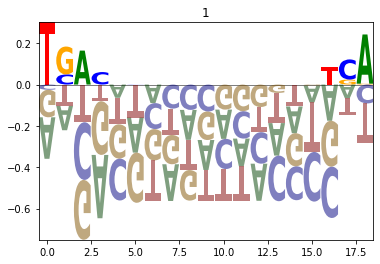

sorted
   expand.left  expand.right  shift      loss
0            2             1      0  0.155378
1            1             2      0  0.157281
2            2             2      0  0.192696
3            1             1      0  0.197420
4            0             0      0  0.223988
action: (2, 1, 0)


optimize_motif_shift (again)...
next expand left: 1, next expand right: 1, shift: 0
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.167471 , best epoch: 2 secs per epoch: 0.624 s
Epoch: 18, Loss: 0.1608 , best epoch: 2 secs per epoch: 0.603 s
early stop!
total time: 10.258 s
secs per epoch: 0.603 s
after opt.

#activities
[[[7.3763011e-05]
  [8.5140246e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


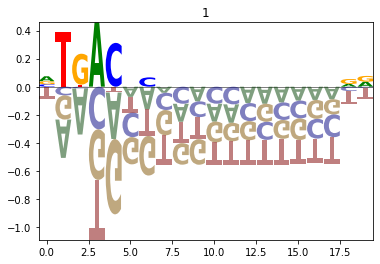

sorted
   expand.left  expand.right  shift      loss
0            0             0      0  0.155378
1            1             1      0  0.156630
action: (0, 0, 0)


optimize_motif_shift (first)...
sorted
   expand.left  expand.right  shift      loss
0            0             0      0  0.155378
action: (0, 0, 0)

after shift optimz model


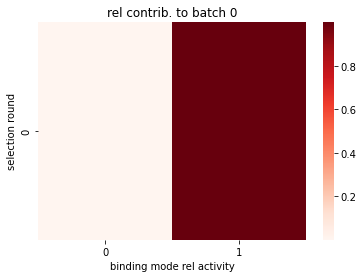


#activities
[[[7.3763011e-05]
  [8.5215306e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


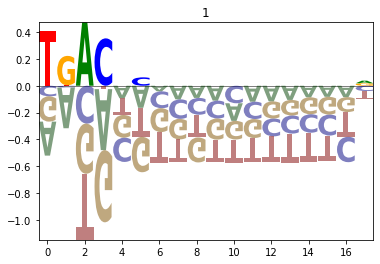

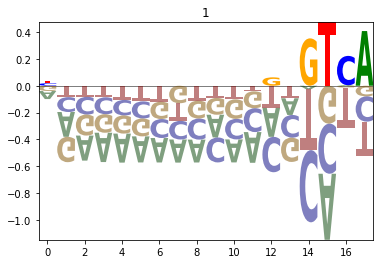

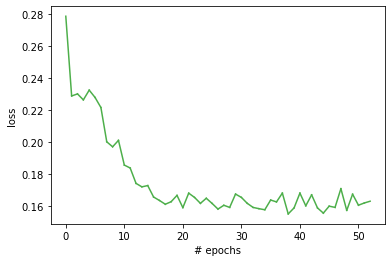




final refinement step (after shift)...

unfreezing all layers for final refinement
kernel grad (0) = 1 
kernel grad (1) = 1 

kernels mask None
optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.MSELoss'> n_epochs 100 early_stopping 15
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.164238 , best epoch: 1 secs per epoch: 0.665 s
Epoch: 17, Loss: 0.1646 , best epoch: 1 secs per epoch: 0.642 s
early stop!
total time: 10.274 s
secs per epoch: 0.642 s

##final motif signal (after final refinement)


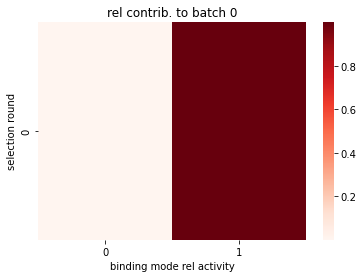


#activities
[[[7.376301e-05]
  [8.514344e-01]]]

#log_etas
Parameter containing:
tensor([[0.]], requires_grad=True)


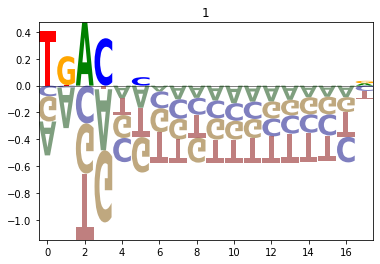

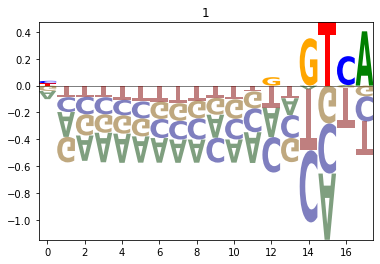

In [9]:
model_by_k_next, res_next = mb.tl.train_iterative(train, device, w=15, n_kernels=2, criterion=mb.tl.MSELoss(), datatype='pbm')